<a href="https://colab.research.google.com/github/psyahmi/CPE-Assessment/blob/main/notebooks/01_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from typing import Tuple, List
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

import torch
from torch.utils.data import DataLoader
from torchvision.datasets import Flowers102
from torchvision import transforms

In [2]:
def set_seed(seed: int = 42) -> None:
  """Set all random seeds for reproductibility"""
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

set_seed(42)

In [23]:
# part1_dataset.py
from torchvision.datasets import Flowers102
from torchvision import transforms

def get_datasets():
    train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ])
    val_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ])

    train_dataset = Flowers102(root='data', split='train', download=True, transform=train_transforms)
    val_dataset = Flowers102(root='data', split='val', download=True, transform=val_transforms)
    test_dataset = Flowers102(root='data', split='test', download=True, transform=val_transforms)

    return train_dataset, val_dataset, test_dataset


In [3]:
def load_raw_dataset(split: str) -> Flowers102:
    """Load Oxford 102 Flowers dataset without transforms (EDA only)."""
    return Flowers102(
        root="data",
        split=split,
        download=True,
        transform=None
    )


train_raw = load_raw_dataset("train")
val_raw = load_raw_dataset("val")
test_raw = load_raw_dataset("test")

100%|██████████| 345M/345M [00:13<00:00, 24.9MB/s]
100%|██████████| 502/502 [00:00<00:00, 1.41MB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 25.2MB/s]


In [4]:
def dataset_summary(dataset: Flowers102) -> None:
    labels = dataset._labels
    print(f"Total images: {len(dataset)}")
    print(f"Number of classes: {len(set(labels))}")


dataset_summary(train_raw)

Total images: 1020
Number of classes: 102


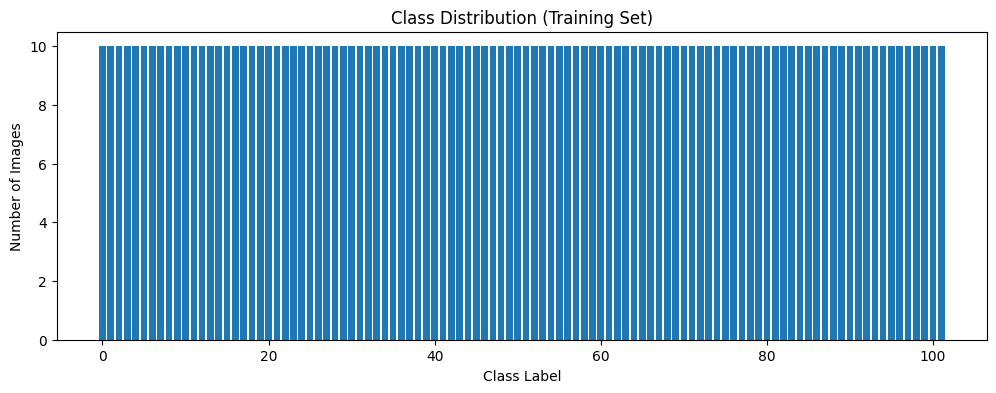

In [5]:
def plot_class_distribution(dataset: Flowers102) -> None:
    labels = dataset._labels
    counts = Counter(labels)

    plt.figure(figsize=(12, 4))
    plt.bar(counts.keys(), counts.values())
    plt.xlabel("Class Label")
    plt.ylabel("Number of Images")
    plt.title("Class Distribution (Training Set)")
    plt.show()


plot_class_distribution(train_raw)

In [6]:
def analyze_image_sizes(
    dataset: Flowers102,
    sample_size: int = 200
) -> Tuple[List[int], List[int]]:
    widths, heights = [], []

    for i in range(sample_size):
        img, _ = dataset[i]  # PIL Image
        w, h = img.size
        widths.append(w)
        heights.append(h)

    return widths, heights

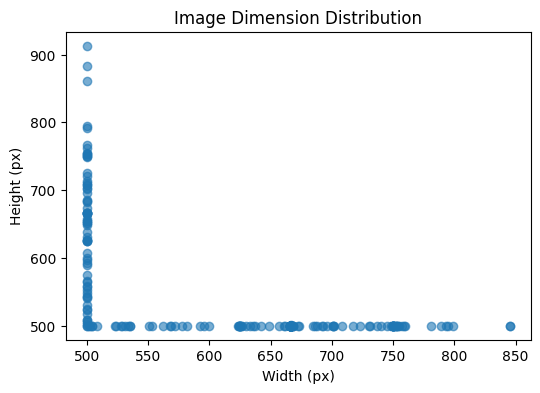

In [7]:
widths, heights = analyze_image_sizes(train_raw)

plt.figure(figsize=(6, 4))
plt.scatter(widths, heights, alpha=0.6)
plt.xlabel("Width (px)")
plt.ylabel("Height (px)")
plt.title("Image Dimension Distribution")
plt.show()

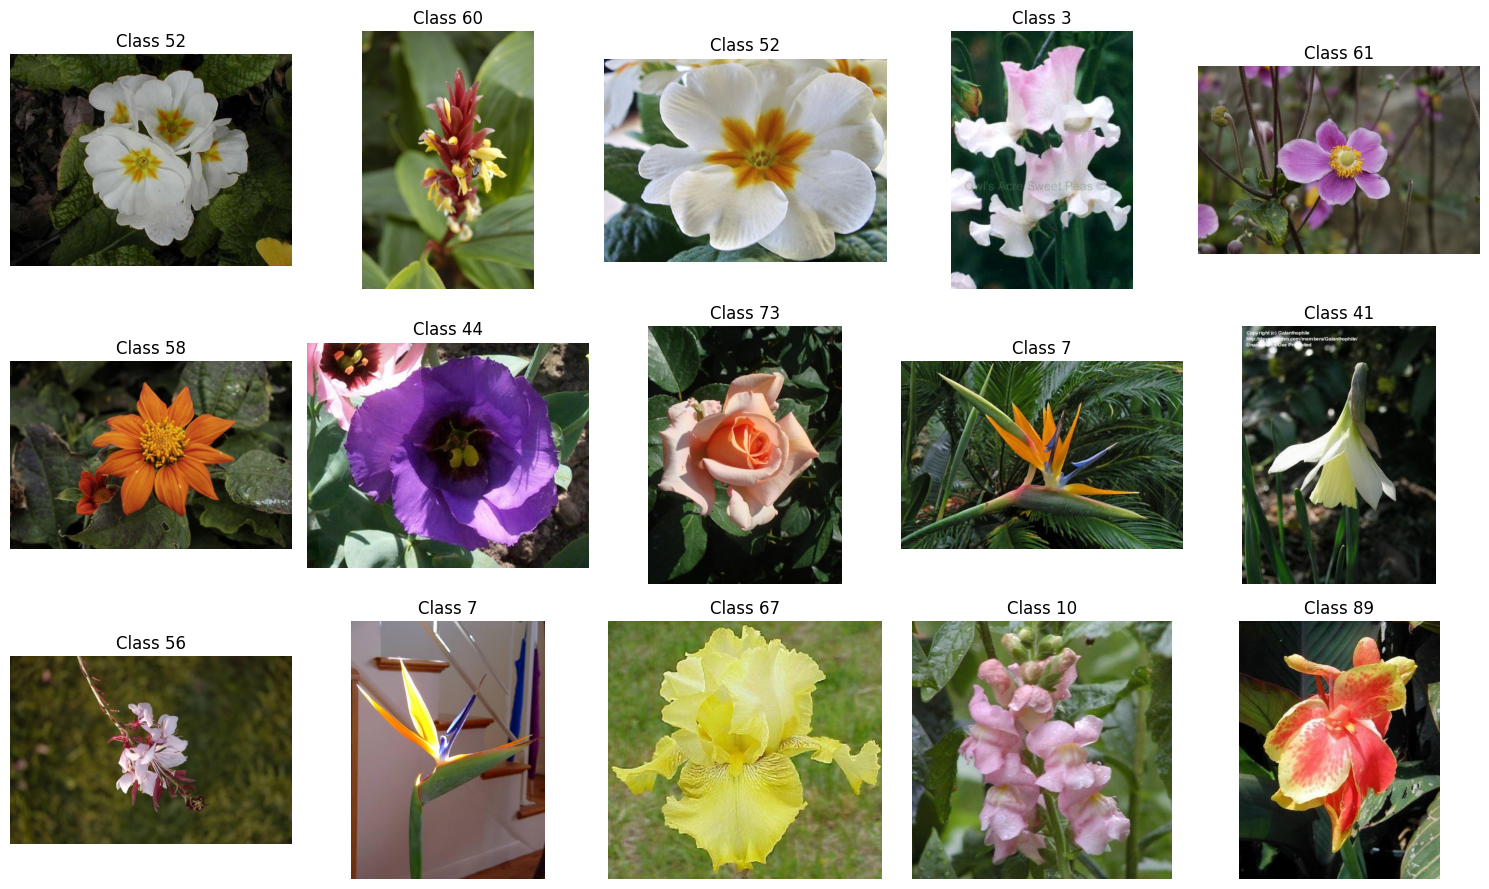

In [8]:
def show_sample_images(
    dataset: Flowers102,
    num_images: int = 15
) -> None:
    indices = np.random.choice(len(dataset), num_images, replace=False)

    fig, axes = plt.subplots(3, 5, figsize=(15, 9))
    for ax, idx in zip(axes.flatten(), indices):
        img, label = dataset[idx]
        ax.imshow(img)
        ax.set_title(f"Class {label}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()


show_sample_images(train_raw)

In [9]:
def get_eval_transforms() -> transforms.Compose:
    """Deterministic transforms for validation & testing."""
    return transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
    ])

In [10]:
def get_train_transforms() -> transforms.Compose:
    """Augmentations for training."""
    return transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(
            brightness=0.2,
            contrast=0.2,
            saturation=0.2,
            hue=0.1
        ),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
    ])

In [11]:
train_dataset = Flowers102(
    root="data",
    split="train",
    download=True,
    transform=get_train_transforms()
)

val_dataset = Flowers102(
    root="data",
    split="val",
    download=True,
    transform=get_eval_transforms()
)

test_dataset = Flowers102(
    root="data",
    split="test",
    download=True,
    transform=get_eval_transforms()
)

In [12]:
def create_dataloader(
    dataset: Flowers102,
    batch_size: int,
    shuffle: bool
) -> DataLoader:
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=2,  # Colab-safe
        pin_memory=True
    )

In [13]:
train_loader = create_dataloader(train_dataset, 32, True)
val_loader = create_dataloader(val_dataset, 32, False)
test_loader = create_dataloader(test_dataset, 32, False)